### Importing Libraries

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pre-processing - Training and Testing sets

In [ ]:
# Set dataset path
base_dir = '/content/drive/MyDrive/Discipline Specific /4th Model/Preprocessed Non Cancerous '

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20               # Initial training epochs
LR = 1e-4
NUM_CLASSES = 4           # e.g., vasc, nv, df, bkl

# 2. DATA GENERATORS

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% for validation
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print the mapping to verify (example: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3})
print("Class indices:", train_generator.class_indices)

# Define class weights
class_weight = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3}


### Building the VGG16 Model
Model Structure:
- **Base Model:** VGG16 (Pretrained on ImageNet, Excludes Fully Connected Layers)
  - Conv Block 1: 2 Conv Layers → MaxPooling
  - Conv Block 2: 2 Conv Layers → MaxPooling
  - Conv Block 3: 3 Conv Layers → MaxPooling
  - Conv Block 4: 3 Conv Layers → MaxPooling
  - Conv Block 5: 3 Conv Layers → MaxPooling
  - Output: Feature maps from final convolutional layer

- **Custom Classification Head:**
  - Global Average Pooling Layer (Reduces feature maps to a single 1D vector)
  - Fully Connected Layer (1024 neurons, ReLU activation, L2 regularization)
  - Dropout Layer (60% dropout to reduce overfitting)
  - Output Layer (Softmax activation for multi-class classification)

- **Training Phases:**
  - **Phase 1 (Feature Extraction):** Freeze all VGG16 layers, train only the classification head.
  - **Phase 2 (Fine-Tuning):** Unfreeze last convolutional block (block5_), update selected layers with a lower learning rate.


In [ ]:
# Load VGG16 with ImageNet weights (excluding the fully connected top layers)
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3))

#Freeze the base model layers to retain pretrained features during initial training
for layer in base_model.layers:
    layer.trainable = False

#Add a custom classification head with added regularization to reduce overfitting
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a 1D feature vector
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)  #Fully connected layer with L2 regularization
x = Dropout(0.6)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

#Define the complete model combining VGG16 and the custom head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model for the initial training phase
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

#############################
# TRAINING - PHASE 1 WITH CLASS WEIGHTS
#############################

# Save the best model during training based on validation accuracy
checkpoint = ModelCheckpoint('best_model_vgg16_phase1.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Stop training early if validation loss does not improve for 5 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           restore_best_weights=True)

# Combine callbacks for training
callbacks_list = [checkpoint, early_stop]

# Train the model using class weights to handle class imbalance
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,  # Apply early stopping and model checkpointing
    class_weight=class_weight  # Adjust class importance during training
)

#############################
# FINE-TUNING (PHASE 2)
#############################

# Unfreeze only the last convolutional block ('block5_') for fine-tuning
for layer in base_model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True

# Recompile the model with a lower learning rate to fine-tune the last layers
model.compile(
    optimizer=Adam(learning_rate=1e-5),  #Lower LR prevents drastic weight updates
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save the best fine-tuned model based on validation accuracy
checkpoint_ft = ModelCheckpoint('best_model_vgg16_finetune.h5',
                                monitor='val_accuracy',
                                save_best_only=True,
                                mode='max',
                                verbose=1)

# Early stopping for fine-tuning phase
early_stop_ft = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                              restore_best_weights=True)

# Combine fine-tuning callbacks
callbacks_list_ft = [checkpoint_ft, early_stop_ft]

# Continue training for fine-tuning with a few additional epochs
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=10,  #Additional fine-tuning epochs
    callbacks=callbacks_list_ft,
    class_weight=class_weight  # Apply class weights during fine-tuning as well
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3893 - loss: 2.3911 
Epoch 1: val_accuracy improved from -inf to 0.69000, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1666s 17s/step - accuracy: 0.3906 - loss: 2.3847 - val_accuracy: 0.6900 - val_loss: 0.8927
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7033 - loss: 1.0085
Epoch 2: val_accuracy improved from 0.69000 to 0.76625, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.7034 - loss: 1.0079 - val_accuracy: 0.7663 - val_loss: 0.7188
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7781 - loss: 0.7361
Epoch 3: val_accuracy improved from 0.76625 to 0.80125, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 322ms/step - accuracy: 0.7782 - loss: 0.7359 - val_accuracy: 0.8012 - val_loss: 0.5828
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8024 - loss: 0.6172
Epoch 4: val_accuracy did not improve from 0.80125
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.8025 - loss: 0.6169 - val_accuracy: 0.7975 - val_loss: 0.5986
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8518 - loss: 0.5205
Epoch 5: val_accuracy improved from 0.80125 to 0.81125, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.8518 - loss: 0.5200 - val_accuracy: 0.8112 - val_loss: 0.5667
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8588 - loss: 0.4487
Epoch 6: val_accuracy improved from 0.81125 to 0.81250, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - accuracy: 0.8588 - loss: 0.4486 - val_accuracy: 0.8125 - val_loss: 0.5390
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8792 - loss: 0.3876
Epoch 7: val_accuracy improved from 0.81250 to 0.81625, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 361ms/step - accuracy: 0.8792 - loss: 0.3875 - val_accuracy: 0.8163 - val_loss: 0.5301
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8956 - loss: 0.3652
Epoch 8: val_accuracy improved from 0.81625 to 0.83125, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 327ms/step - accuracy: 0.8957 - loss: 0.3651 - val_accuracy: 0.8313 - val_loss: 0.4826
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9092 - loss: 0.3355
Epoch 9: val_accuracy did not improve from 0.83125
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 326ms/step - accuracy: 0.9091 - loss: 0.3356 - val_accuracy: 0.8213 - val_loss: 0.4981
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9172 - loss: 0.3076
Epoch 10: val_accuracy did not improve from 0.83125
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - accuracy: 0.9172 - loss: 0.3076 - val_accuracy: 0.8175 - val_loss: 0.5215
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9236 - loss: 0.2812
Epoch 11: val_accuracy improved from 0.83125 to 0.84125, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - accuracy: 0.9235 - loss: 0.2813 - val_accuracy: 0.8413 - val_loss: 0.4631
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9320 - loss: 0.2583
Epoch 12: val_accuracy improved from 0.84125 to 0.84875, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 326ms/step - accuracy: 0.9320 - loss: 0.2583 - val_accuracy: 0.8487 - val_loss: 0.4530
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9273 - loss: 0.2647
Epoch 13: val_accuracy did not improve from 0.84875
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - accuracy: 0.9273 - loss: 0.2647 - val_accuracy: 0.8375 - val_loss: 0.4603
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9467 - loss: 0.2198
Epoch 14: val_accuracy did not improve from 0.84875
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 320ms/step - accuracy: 0.9467 - loss: 0.2201 - val_accuracy: 0.8413 - val_loss: 0.4565
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9439 - loss: 0.2303
Epoch 15: val_accuracy did not improve from 0.84875
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.9439 - loss: 0.2303 - val_accuracy: 0.8225 - val_loss: 0.4833
Epoch 16/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9509 - loss: 0.2187
Epoch 16

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - accuracy: 0.9321 - loss: 0.2617 - val_accuracy: 0.8575 - val_loss: 0.3944
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9510 - loss: 0.1984
Epoch 2: val_accuracy improved from 0.85750 to 0.87500, saving model to best_model_vgg16_finetune.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 350ms/step - accuracy: 0.9510 - loss: 0.1984 - val_accuracy: 0.8750 - val_loss: 0.3953
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9663 - loss: 0.1657
Epoch 3: val_accuracy improved from 0.87500 to 0.89000, saving model to best_model_vgg16_finetune.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 341ms/step - accuracy: 0.9663 - loss: 0.1656 - val_accuracy: 0.8900 - val_loss: 0.3384
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9758 - loss: 0.1365
Epoch 4: val_accuracy improved from 0.89000 to 0.90375, saving model to best_model_vgg16_finetune.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - accuracy: 0.9758 - loss: 0.1366 - val_accuracy: 0.9038 - val_loss: 0.2975
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9823 - loss: 0.1197
Epoch 5: val_accuracy did not improve from 0.90375
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 344ms/step - accuracy: 0.9823 - loss: 0.1197 - val_accuracy: 0.8900 - val_loss: 0.3415
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9815 - loss: 0.1181
Epoch 6: val_accuracy did not improve from 0.90375
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 336ms/step - accuracy: 0.9815 - loss: 0.1180 - val_accuracy: 0.8850 - val_loss: 0.4488
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9896 - loss: 0.0975
Epoch 7: val_accuracy did not improve from 0.90375
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.9896 - loss: 0.0976 - val_accuracy: 0.8250 - val_loss: 0.5260
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9951 - loss: 0.0903
Epoch 8: val_ac

### Evaluation Metrics - Performance of the Model

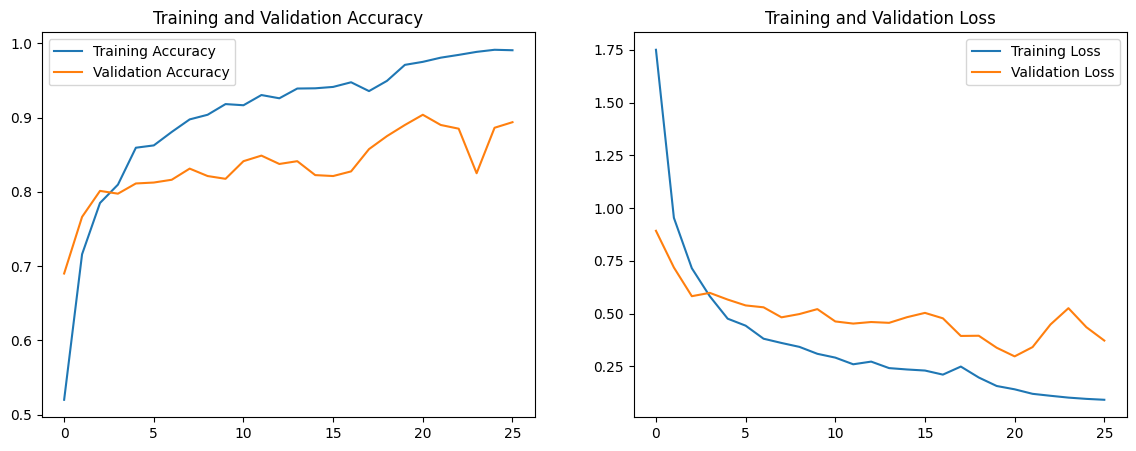

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step


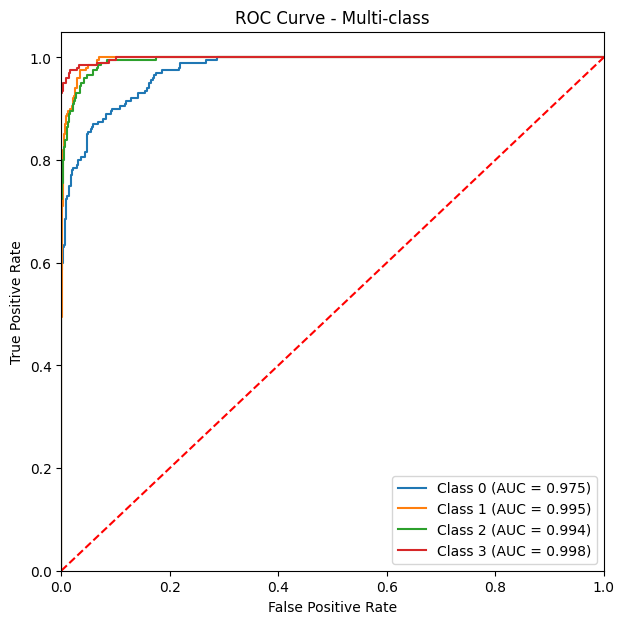

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step
Confusion Matrix:
[[165   0  28   7]
 [ 19 172   7   2]
 [  5   1 193   1]
 [  0   5   2 193]]


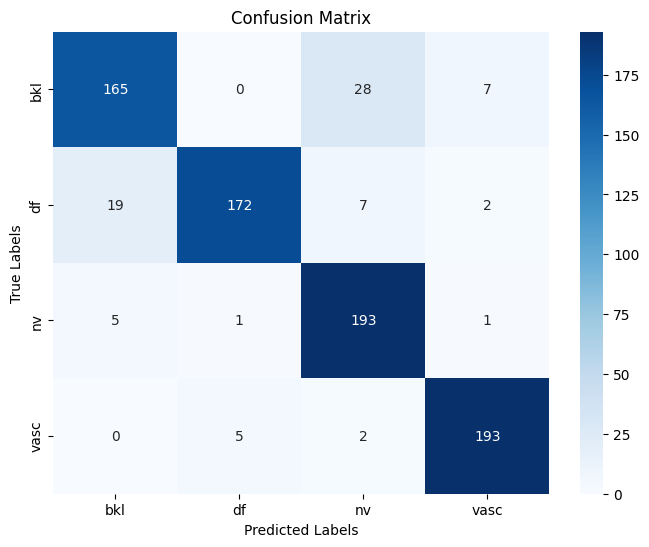

Classification Report:
              precision    recall  f1-score   support

         bkl       0.87      0.82      0.85       200
          df       0.97      0.86      0.91       200
          nv       0.84      0.96      0.90       200
        vasc       0.95      0.96      0.96       200

    accuracy                           0.90       800
   macro avg       0.91      0.90      0.90       800
weighted avg       0.91      0.90      0.90       800



In [ ]:

#############################
# PLOT ACCURACY & LOSS
#############################
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#############################
#  EVALUATE AUC-ROC
#############################
valid_generator.reset()
y_pred_proba = model.predict(valid_generator)
y_true = valid_generator.classes
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
plt.figure(figsize=(7, 7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.3f})'.format(i, roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

#############################
# CONFUSION MATRIX & CLASSIFICATION REPORT
#############################
valid_generator.reset()
steps = math.ceil(valid_generator.samples / valid_generator.batch_size)
y_pred = model.predict(valid_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)
# Create a list for class labels based on the generator mapping
class_labels = [None] * len(train_generator.class_indices)
for label, idx in train_generator.class_indices.items():
    class_labels[idx] = label
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)


### Validation Accuracy for the Best Model

In [ ]:
valid_generator.reset()
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy from Model Evaluation: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.8817 - loss: 0.3530
Validation Accuracy from Model Evaluation: 0.9038
